- Scikit pipeline?
- Napravi grader da proceni koliko je tezak primer i primeni na svim
- Import podataka -> Train/Valid split N puta -> Generisanje suma samo za train (da bi mogli da se uverimo da zaista daje dobre rezultate, ako poremetimo valid set mozda greskom dobijemo dobre ili lose rez.) -> 
    Transformacije (SkewTest+Norm/Stand, SMOTE, Method specific transf) - train na train, apply na valid ->
    Trening na train, validacija na valid -> viz i cuvanje
- Sacuvaj - za svaku kombinaciju transf, modela i generisanje suma po jedan entry u pd da bi uzeli najbolje
- Vizuelizacije - Preciznost standardna za svaki difficulty + broj pogodjenih?, za difficulty-e, grafikon za top 5-10 metoda kao linija, grafikon gde su outlieri x-ovi ali zeleni su dobro a crveni lose klasifikovani
- Ako izbacujes ispisi koliko lakih, srednjih, teskih je izbaceno

# Import

In [2]:
%pip install kagglehub openpyxl imbalanced-learn seaborn torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import VotingClassifier

# Load data

In [4]:
import kagglehub as kg
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

C:\Users\dmilo\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
path = kg.dataset_download("muratkokludataset/dry-bean-dataset")
file_name = '/Dry_Bean_Dataset/Dry_Bean_Dataset.xlsx'
print("Downloaded at: ", path)
data = pd.read_excel(path+file_name)
data

Downloaded at:  C:\Users\dmilo\.cache\kagglehub\datasets\muratkokludataset\dry-bean-dataset\versions\1


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON


In [6]:
def encode_n_split(data: pd.DataFrame, train_percentage: float, encoder: TransformerMixin, class_column:str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, str] :
    """
        returns tuple containing train, test and valid sets, string representing the label column and the trained encoder
    """
    datacp = data.copy()
    encoded_class_column = f"Class_{encoder.__class__.__name__}"
    datacp[encoded_class_column] = encoder.fit_transform(datacp[class_column])
    datacp.drop(inplace=True, axis=1, labels=[class_column])

    test_percentage = 1 - train_percentage

    split = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=42)

    # Perform the split
    for train_idx, test_idx in split.split(datacp, datacp[encoded_class_column]):
        train_set = datacp.iloc[train_idx]
        test_set = datacp.iloc[test_idx]

    split = StratifiedShuffleSplit(n_splits=1, test_size=test_percentage, random_state=42)
    for train_idx, valid_idx in split.split(train_set, train_set[encoded_class_column]):
        valid_set = datacp.iloc[valid_idx]
        train_set = train_set.iloc[train_idx]

    print('Train size: ', len(train_set), 'x', len(train_set.iloc[0]))
    print('Test size: ', len(test_set), 'x', len(test_set.iloc[0]))
    print('Valid size: ', len(test_set), 'x', len(test_set.iloc[0]))
    print(f'Encoded classes in column "{encoded_class_column}"')
    return (train_set, test_set, valid_set, encoder, encoded_class_column)


In [7]:
train_set, test_set, valid_set, encoder, encoded_class_column = encode_n_split(data, 0.8, LabelEncoder(), 'Class')

Train size:  8710 x 17
Test size:  2723 x 17
Valid size:  2723 x 17
Encoded classes in column "Class_LabelEncoder"


In [8]:
y_train = train_set[encoded_class_column]
y_test = test_set[encoded_class_column]
y_valid = valid_set[encoded_class_column]
X_train = train_set.drop(axis = 1, labels=[encoded_class_column])
X_valid = valid_set.drop(axis = 1, labels=[encoded_class_column])
X_test = test_set.drop(axis = 1, labels=[encoded_class_column])

# EDA

In [9]:
n_classes, class_counts = np.unique(y_train, return_counts = True)

In [10]:
from helper.plot import plot_attr_label, plot_attributes, plot_difficulties
import seaborn as sns

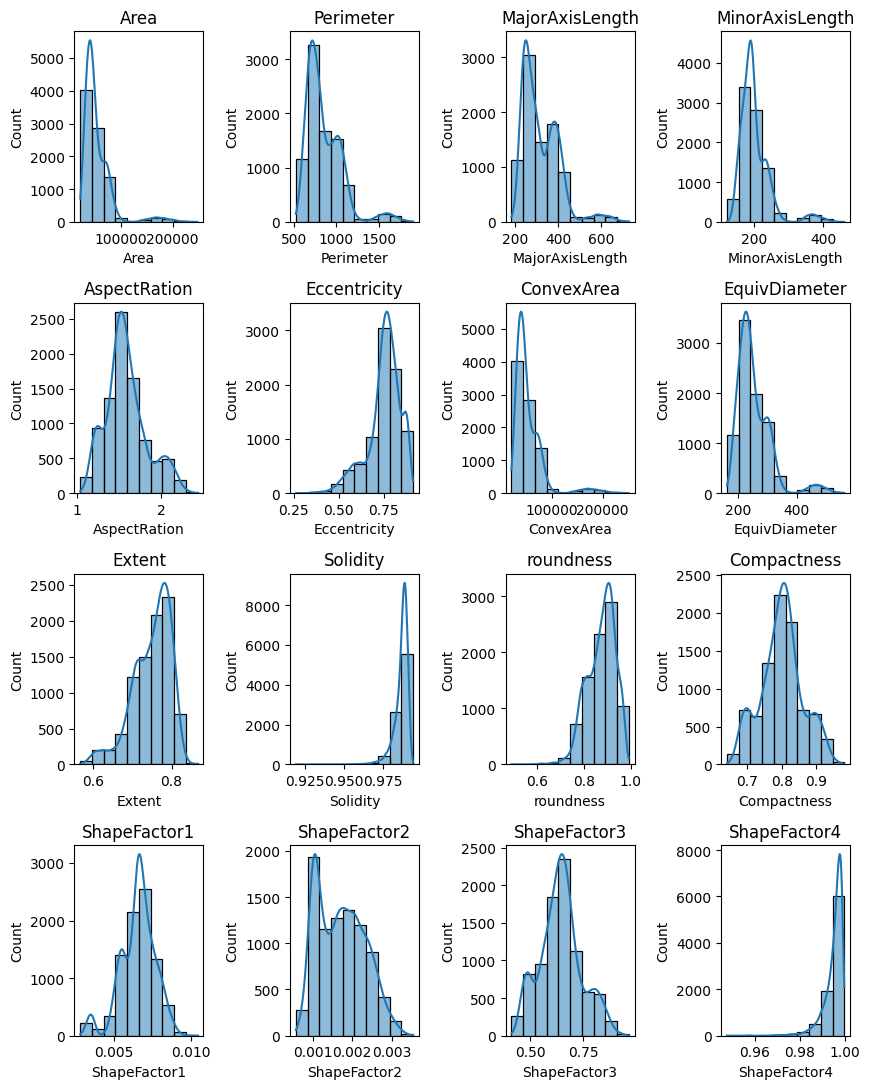

In [11]:
plot_attributes(X_train, label_column = encoded_class_column, n_attrs = len(class_counts))

Atributi 
- Area
- Perimeter
- Major Axis Length
- Minor Axis Length
- AspectRation
- ConvexArea
- EquivDiameter 

imaju dosta velike vrednosti dok ostali atributi su u range $[0-1]$ \
Sa grafikona vidimo da vrednosti atributa ne prate normalnu raspodelu.\
Atributi kao ShapeFactor4 i Solidity imaju velike repove. Zato ćemo tokom preprocesiranja normalizovati raspodele.

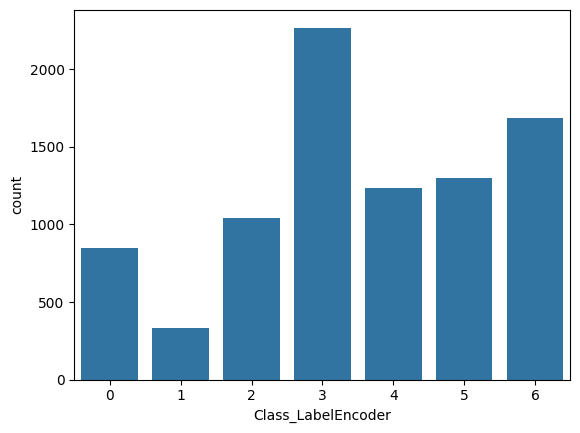

In [12]:
_ = sns.countplot(data = y_train.to_frame(), x = encoded_class_column)

Pored toga skup podataka nije balansiran:
- Klasa 1 je slabo zastupljena sa manje od 500 instanci, klasa 0 ima oko 1000 dok klasa 3 dominira sa oko 2500 instanci
- Zato ćemo izvršiti under i oversampling na oko 500-1000 instanci

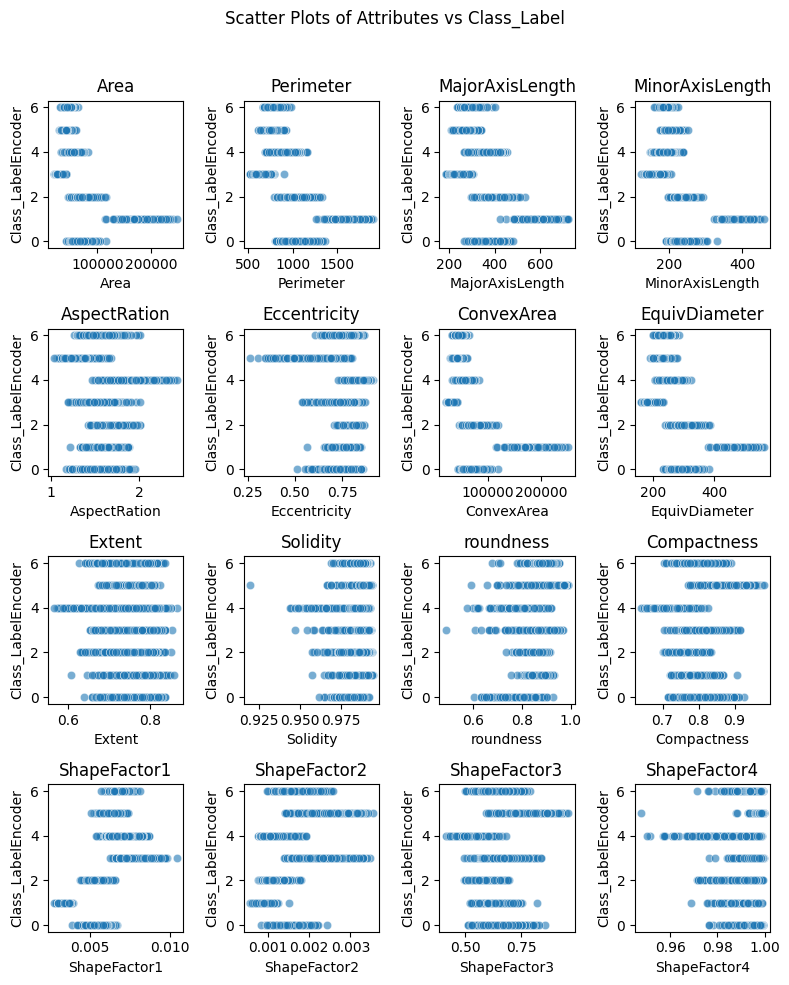

In [13]:
plot_attr_label(X_train, y_train)

Po grafikonu iznad vidimo da se klasa 1 karakteriše visokim vrednostima Major i Minor axis length, EquivDiameter, ConvexArea, Area i Perimeter. Pored toga ima male vrednosti ShapeFactor1.

<div style="background-color:#1212AA; height:auto; border-radius:10px; padding:16px; width:600px; color:white">
<h3>Zaključci</h3>
<ul>
<li>Podaci su nebalansirani, potrebno je under i over sample-ovati na oko 1-1.5 hiljade instanci</li>
<li>Atribute je potrebno normalizovati, a neke i skalirati kao što su Area</li>
<li>Klasa 1 je nedovoljno zastupljena ali lako prepoznatljiva po atributima koji imaju visoke vrednosti kao što je Area</li>
</ul>
</div>


# Normalizacija/Standardizacija

In [15]:
pt = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt.fit_transform(X_train)
X_test_transformed = pt.transform(X_test)

C:\Users\dmilo\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [16]:
scaler = MinMaxScaler()
train_set_scaled = scaler.fit_transform(X_train_transformed)
test_set_scaled = scaler.transform(X_test_transformed)
X_train_transformed = pd.DataFrame(train_set_scaled, columns=X_train.columns)
X_test_transformed = pd.DataFrame(test_set_scaled, columns=X_test.columns)

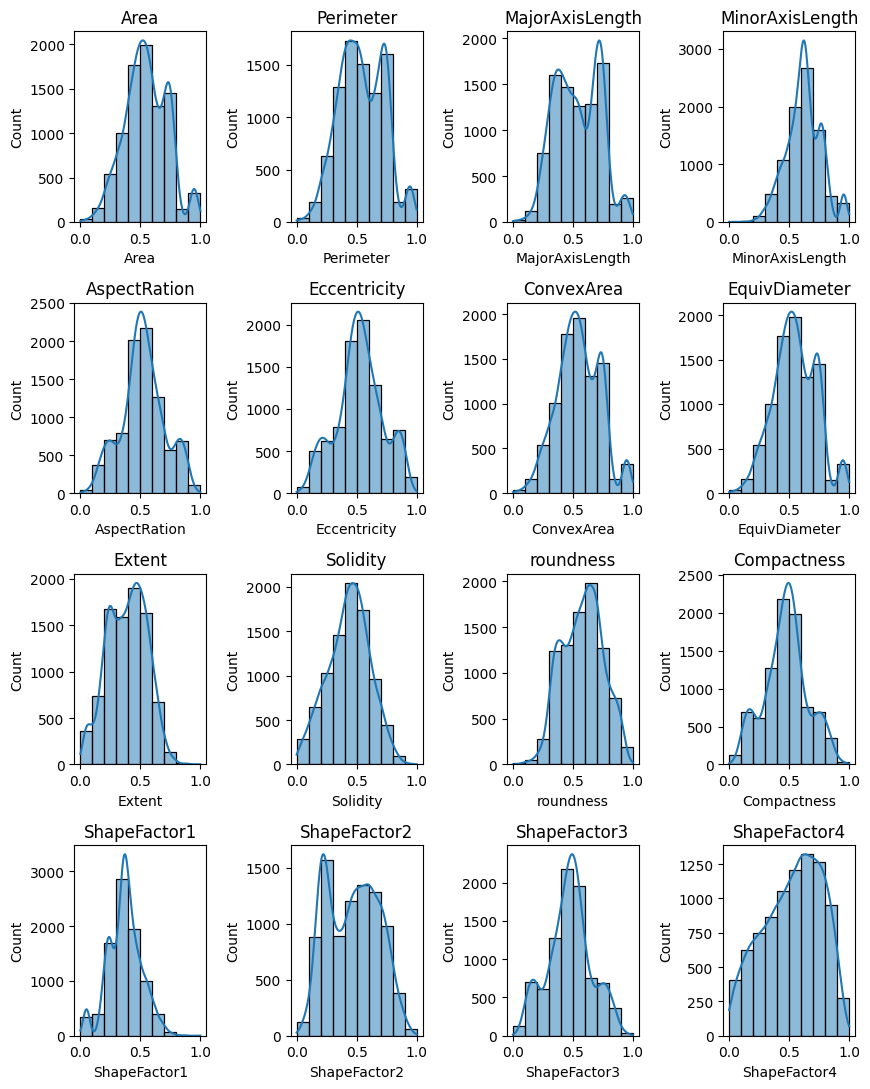

In [17]:
plot_attributes(X_train_transformed, label_column = encoded_class_column, n_attrs = len(class_counts))

Podaci sada prate raspodele dosta bliže normalnoj raspodeli

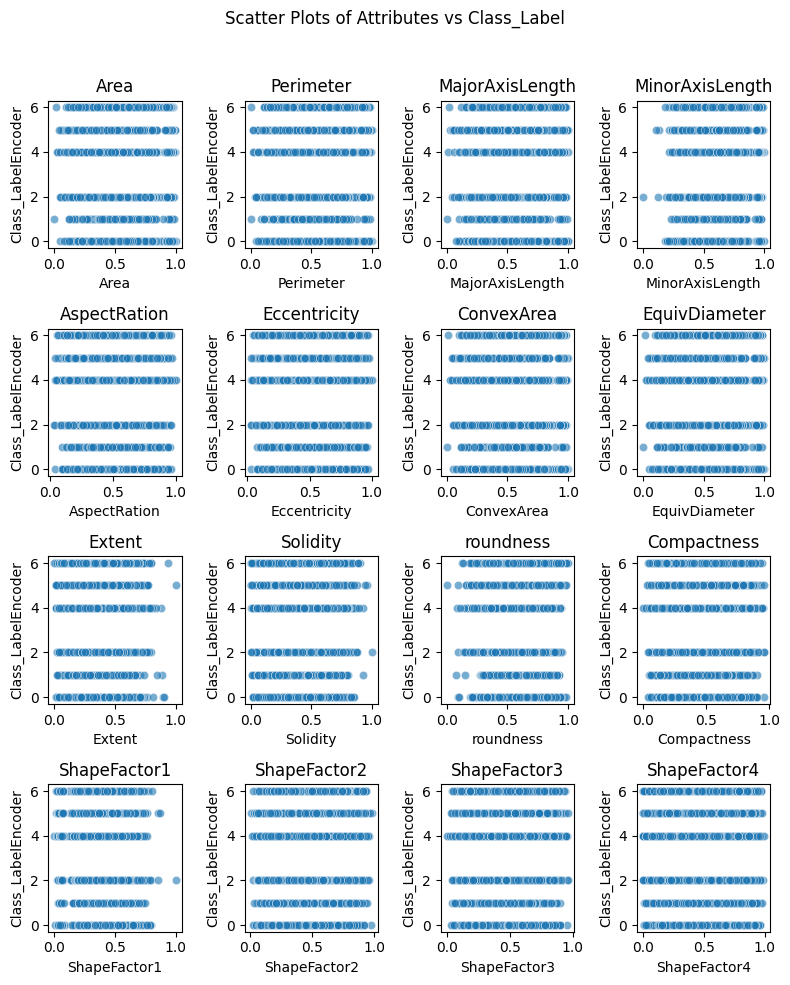

In [18]:
plot_attr_label(X_train_transformed, y_train)

Da li uopste da se primeni PowerTransform? Unistava skroz specificnosti nekih klasa